In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ts_val_shuffle import FeaturesGenerator, Validator, MAPE, SMAPE, WAPE

c:\University\kurs_3\semestr_2\практика\TSValShuffle\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\University\kurs_3\semestr_2\практика\TSValShuffle\venv\Lib\site-packages\symfit\core\printing.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Для теста выбран датасет [Electric Production](https://www.kaggle.com/datasets/shenba/time-series-datasets/data?select=Electric_Production.csv)

In [2]:
df = pd.read_csv(r"data\Electric_Production.csv")

df = df.rename(columns={"IPG2211A2N": "value", "DATE": "date"})

df['date'] = pd.to_datetime(df['date'])
print(df.head())

        date    value
0 1985-01-01  72.5052
1 1985-02-01  70.6720
2 1985-03-01  62.4502
3 1985-04-01  57.4714
4 1985-05-01  55.3151


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    397 non-null    datetime64[ns]
 1   value   397 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB
None


In [4]:
train = df.iloc[:-48]
test = df.iloc[-60:] # 60, т.к. при генерации признаков 12 первых будут отброшены

## Пример с использованием Fourie из библиотеки symfit

### Инициализация гиперпараметров модели

In [5]:
init_params = {
    "order": 5, # обязательный параметр
    #"absolute_sigma": True, # опционально
}

### Инициализируется валидатор

Для работы нужно выполнить 4 этапа:
1) Инициализировать исходный временный ряд;
2) Сгенерировать признаки, передав путь к JSON файлу;
3) Установить модель, задав название модели и её гиперпараметры;
4) Установить метод кросс-валидации и количество фолдов с размером тестовой выборки (заранее необходимо выполнить этапы 1 и 2);
5) Провести кросс-валидацию модели, задав метрику, название целевого признака и временного признака из исходных данных

In [6]:
val = Validator()

val.set_data(train)
val.set_generator(r"data\config.json")
val.set_model("Fourie", init_params)
val.set_split_method("rolling", 10)
val.validate("WAPE", 'value', 'date')

In [7]:
print(pd.Series(val.metric_values))

0    0.066518
1    0.087190
2    0.034387
3    0.093908
4    0.104382
5    0.067923
6    0.078242
7    0.101195
8    0.103575
9    0.078922
dtype: float64


### Значения метрики WAPE в процессе кросс-валидации

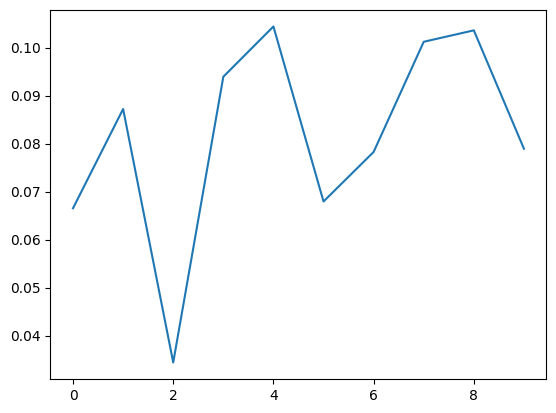

In [8]:
plt.plot(val.metric_values)
plt.show()

### Генерируем признаки для теста обученной модели

In [9]:
gen = FeaturesGenerator(r"data\config.json")
test = gen.generate_features(test)

print(test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, 349 to 396
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          48 non-null     datetime64[ns]
 1   value         48 non-null     float64       
 2   lag_6         48 non-null     float64       
 3   lag_12        48 non-null     float64       
 4   diff_lag_12   48 non-null     float64       
 5   diff_lag_6    48 non-null     float64       
 6   std_7         48 non-null     float64       
 7   mean_5_lag_5  48 non-null     float64       
 8   year          48 non-null     int32         
 9   month_cos     48 non-null     float64       
dtypes: datetime64[ns](1), float64(8), int32(1)
memory usage: 3.9 KB
None


In [10]:
test = test.drop(columns=['date', 'value']) # приводим в вид, в котором модель обучалась
print(test.head())

        lag_6    lag_12  diff_lag_12  diff_lag_6      std_7  mean_5_lag_5  \
349  108.1756  106.7340       6.1471      4.7055  10.423190     107.93632   
350   99.2809  102.9948       1.7683      5.4822  10.424168     110.53152   
351   91.7871   91.0092      -0.7225     -1.5004  11.681991     109.13180   
352   97.2853   90.9634       1.1706     -5.1513  11.626601     104.86396   
353  113.4732  100.6957       1.1823    -11.5952  11.297024     100.38858   

     year     month_cos  
349  2014  5.000000e-01  
350  2014  6.123234e-17  
351  2014 -5.000000e-01  
352  2014 -8.660254e-01  
353  2014 -1.000000e+00  


### Предсказываем на выборке, которую модель ещё не видела

In [11]:
predict_params = {
    'X': test
}
pred = val.predict(predict_params)

print(pred.info())

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, 349 to 396
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes
None


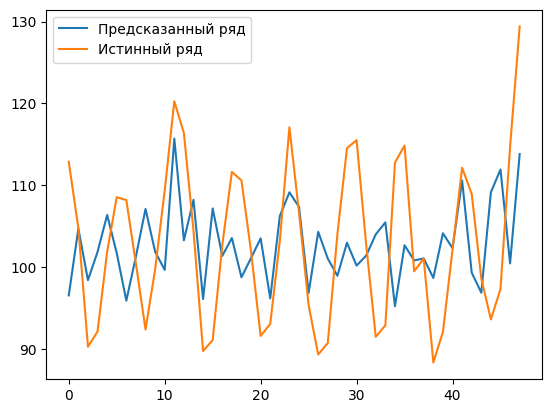

In [12]:
plt.plot(np.arange(0, 48), pred['prediction'].values[-48:], label='Предсказанный ряд')
plt.plot(np.arange(0, 48), df['value'][-48:], label='Истинный ряд')
plt.legend()
plt.show()

### Сравнение предсказанных и истинных данных

In [13]:
res = pd.DataFrame({
    'date': df['date'][-48:].values,
    'y_pred': pred['prediction'].values[-48:],
    'y_true': df['value'][-48:].values
})
print(res)

         date      y_pred    y_true
0  2014-02-01   96.548499  112.8811
1  2014-03-01  104.709460  104.7631
2  2014-04-01   98.415341   90.2867
3  2014-05-01  101.862391   92.1340
4  2014-06-01  106.371611  101.8780
5  2014-07-01  101.721918  108.5497
6  2014-08-01   95.903659  108.1940
7  2014-09-01  101.311166  100.4172
8  2014-10-01  107.110202   92.3837
9  2014-11-01  101.891154   99.7033
10 2014-12-01   99.660399  109.3477
11 2015-01-01  115.706111  120.2696
12 2015-02-01  103.280812  116.3788
13 2015-03-01  108.225239  104.4706
14 2015-04-01   96.097224   89.7461
15 2015-05-01  107.168805   91.0930
16 2015-06-01  101.377039  102.6495
17 2015-07-01  103.557263  111.6354
18 2015-08-01   98.760026  110.5925
19 2015-09-01  101.116298  101.9204
20 2015-10-01  103.516681   91.5959
21 2015-11-01   96.177588   93.0628
22 2015-12-01  106.254991  103.2203
23 2016-01-01  109.140645  117.0837
24 2016-02-01  107.363082  106.6688
25 2016-03-01   96.858850   95.3548
26 2016-04-01  104.314043   

### Значение метрики WAPE в данном случае

In [14]:
print(WAPE(res['y_true'], res['y_pred']))

0.07894218219664191
